In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [5]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [6]:
df = df.drop(['customerID'], axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype('float64')

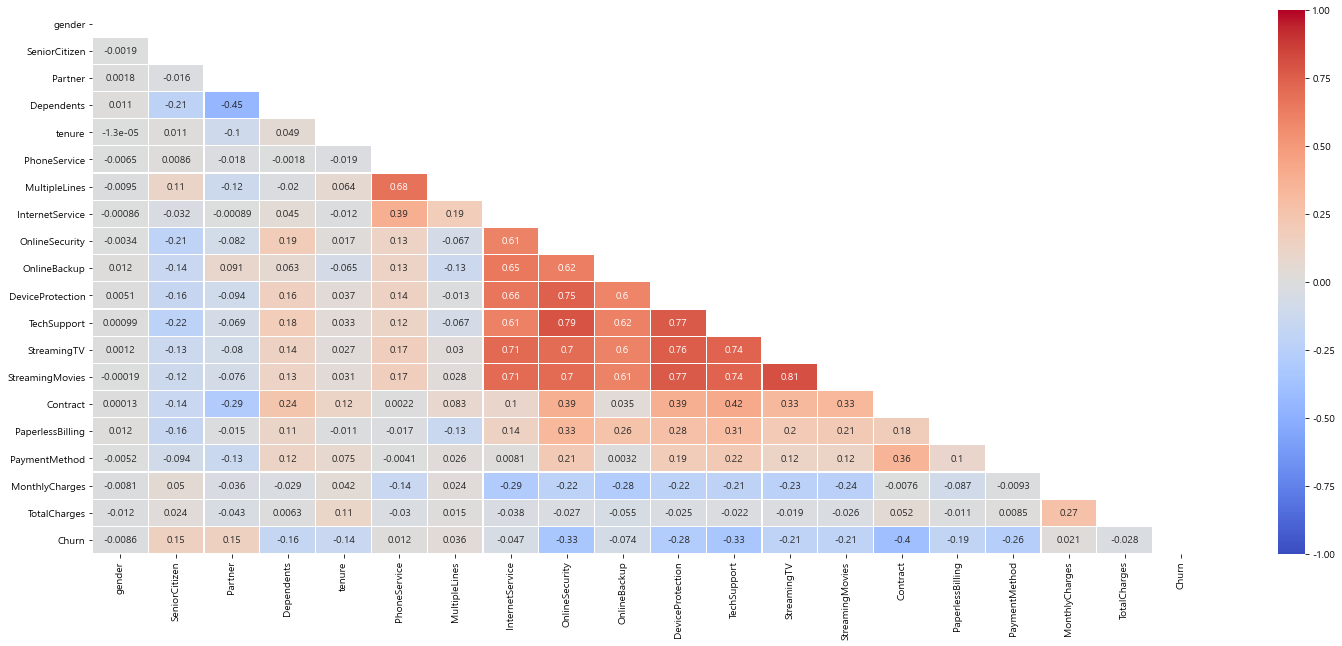

In [8]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [9]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
use_cols = ['SeniorCitizen', 'Partner', 'Dependents', 
            'tenure', 'OnlineSecurity', 'Contract', 
            'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn']
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categoric_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'Contract', 
            'PaperlessBilling', 'PaymentMethod']

In [11]:
use_df = df[use_cols]

In [12]:
use_df.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,Yes,One year,No,Mailed check,56.95,1889.50,No
2,0,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
X = use_df.drop('Churn', axis=1)
y = use_df['Churn']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25, random_state = 42)

In [15]:
Standard_Scaler = StandardScaler()
Standard_Scaler.fit_transform(X_train[numeric_cols])
Standard_Scaler.transform(X_test[numeric_cols])

array([[ 0.79743498,  0.50857948,  0.87770596],
       [ 0.02587053, -1.34596843, -0.6361548 ],
       [-0.90812855, -0.36980336, -0.77510736],
       ...,
       [ 0.26952246,  1.17979655,  0.66067738],
       [-1.19238913, -1.12222941, -0.96152261],
       [-0.13656409, -0.62834623, -0.42000152]])

In [16]:
print(categoric_cols)

['SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [17]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), 
     ['SeniorCitizen', 'Partner',
      'Dependents', 'OnlineSecurity',
      'Contract', 'PaperlessBilling', 'PaymentMethod']))

In [18]:
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_train.index
# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)
# Dropping old categorical columns
X_train.drop(categoric_cols, axis=1, inplace=True)
# CHecking result
X_train.head()

,tenure,MonthlyCharges,TotalCharges,onehotencoder__SeniorCitizen_0,onehotencoder__SeniorCitizen_1,onehotencoder__Partner_No,onehotencoder__Partner_Yes,onehotencoder__Dependents_No,onehotencoder__Dependents_Yes,onehotencoder__OnlineSecurity_No,...,onehotencoder__OnlineSecurity_Yes,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_No,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check
6661,72,53.65,3784.00,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4811,4,46.00,193.60,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2193,56,21.20,1238.65,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1904,56,94.45,5124.60,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6667,9,79.55,723.40,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_test.index
# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)
# Dropping old categorical columns
X_test.drop(categoric_cols, axis=1, inplace=True)
# CHecking result
X_test.head()

,tenure,MonthlyCharges,TotalCharges,onehotencoder__SeniorCitizen_0,onehotencoder__SeniorCitizen_1,onehotencoder__Partner_No,onehotencoder__Partner_Yes,onehotencoder__Dependents_No,onehotencoder__Dependents_Yes,onehotencoder__OnlineSecurity_No,...,onehotencoder__OnlineSecurity_Yes,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_No,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check
5909,52,80.20,4297.6,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3670,33,24.25,838.5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6220,10,53.70,521.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5905,1,85.00,85.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6435,52,50.20,2554.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [20]:
print(X_train.columns)

Index(['tenure', 'MonthlyCharges', 'TotalCharges',
       'onehotencoder__SeniorCitizen_0', 'onehotencoder__SeniorCitizen_1',
       'onehotencoder__Partner_No', 'onehotencoder__Partner_Yes',
       'onehotencoder__Dependents_No', 'onehotencoder__Dependents_Yes',
       'onehotencoder__OnlineSecurity_No',
       'onehotencoder__OnlineSecurity_No internet service',
       'onehotencoder__OnlineSecurity_Yes',
       'onehotencoder__Contract_Month-to-month',
       'onehotencoder__Contract_One year', 'onehotencoder__Contract_Two year',
       'onehotencoder__PaperlessBilling_No',
       'onehotencoder__PaperlessBilling_Yes',
       'onehotencoder__PaymentMethod_Bank transfer (automatic)',
       'onehotencoder__PaymentMethod_Credit card (automatic)',
       'onehotencoder__PaymentMethod_Electronic check',
       'onehotencoder__PaymentMethod_Mailed check'],
      dtype='object')


In [21]:
encoded_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_0',
       'SeniorCitizen_1', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No',
       'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [22]:
X_train.columns = encoded_cols
X_test.columns = encoded_cols

In [23]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,OnlineSecurity_No,...,OnlineSecurity_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6661,72,53.65,3784.00,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4811,4,46.00,193.60,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2193,56,21.20,1238.65,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1904,56,94.45,5124.60,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6667,9,79.55,723.40,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [40]:
rf_classifier = RandomForestClassifier()

param_grid = {
    "max_depth": [10, 100, 1000],
    "min_samples_leaf": [100, 1000],
    "min_samples_split": [100, 1000],
    "criterion": ['entropy', 'gini']
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델을 사용한 예측 및 평가
best_rf = grid_search.best_estimator_
predictions = best_rf.predict(X_test)
print("분류기의 정확도:", accuracy_score(y_test, predictions))
print("\n분류 리포트:\n", classification_report(y_test, predictions))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
최적의 하이퍼파라미터: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}
분류기의 정확도: 0.7921635434412265

분류 리포트:
               precision    recall  f1-score   support

          No       0.81      0.94      0.87      1294
         Yes       0.69      0.40      0.50       467

    accuracy                           0.79      1761
   macro avg       0.75      0.67      0.69      1761
weighted avg       0.78      0.79      0.77      1761



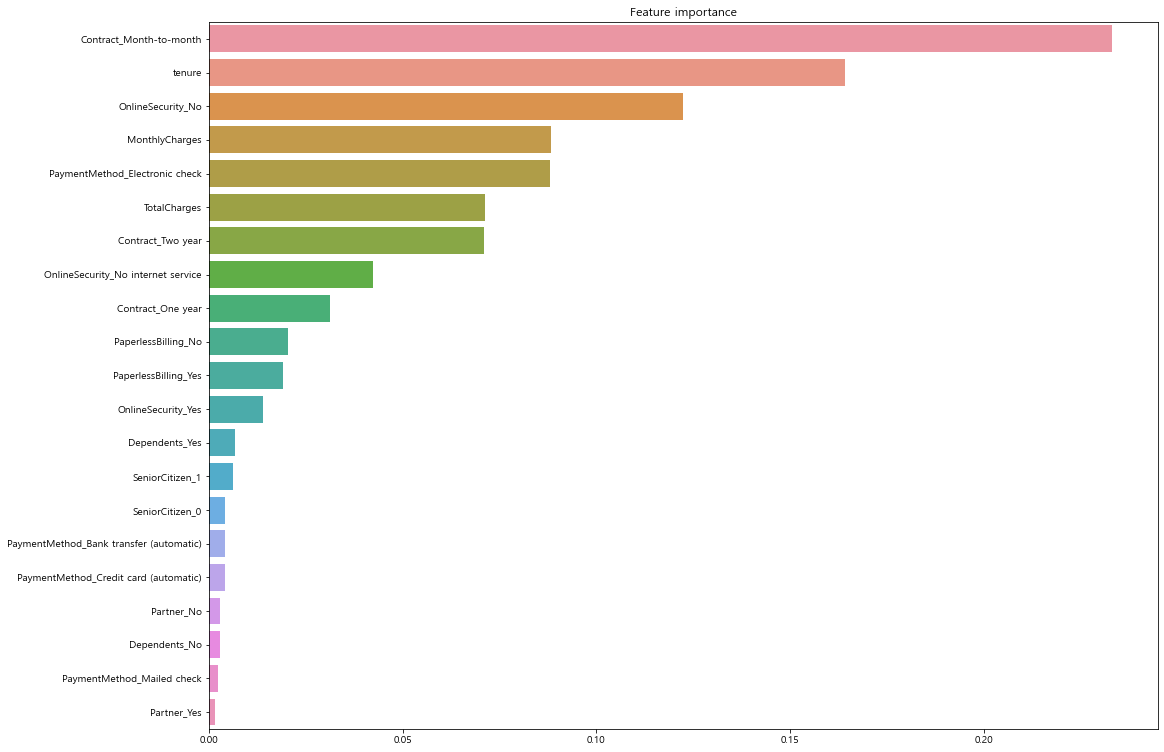

In [45]:
fimp = pd.Series(data=best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, orient='h')

In [43]:
dt_classifier = DecisionTreeClassifier()

param_grid = {
    "max_depth": [10, 100, 1000],
    "min_samples_leaf": [100, 1000],
    "min_samples_split": [100, 1000],
    "criterion": ['entropy', 'gini']
}
grid_search = GridSearchCV(estimator=dt_classifier,
    param_grid=param_grid,
    cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델을 사용한 예측 및 평가
best_dt = grid_search.best_estimator_
predictions = best_dt.predict(X_test)
print("분류기의 정확도:", accuracy_score(y_test, predictions))
print("\n분류 리포트:\n", classification_report(y_test, predictions))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
최적의 하이퍼파라미터: {'criterion': 'entropy', 'max_depth': 1000, 'min_samples_leaf': 100, 'min_samples_split': 100}
분류기의 정확도: 0.7853492333901193

분류 리포트:
               precision    recall  f1-score   support

          No       0.83      0.90      0.86      1294
         Yes       0.63      0.47      0.54       467

    accuracy                           0.79      1761
   macro avg       0.73      0.69      0.70      1761
weighted avg       0.77      0.79      0.77      1761



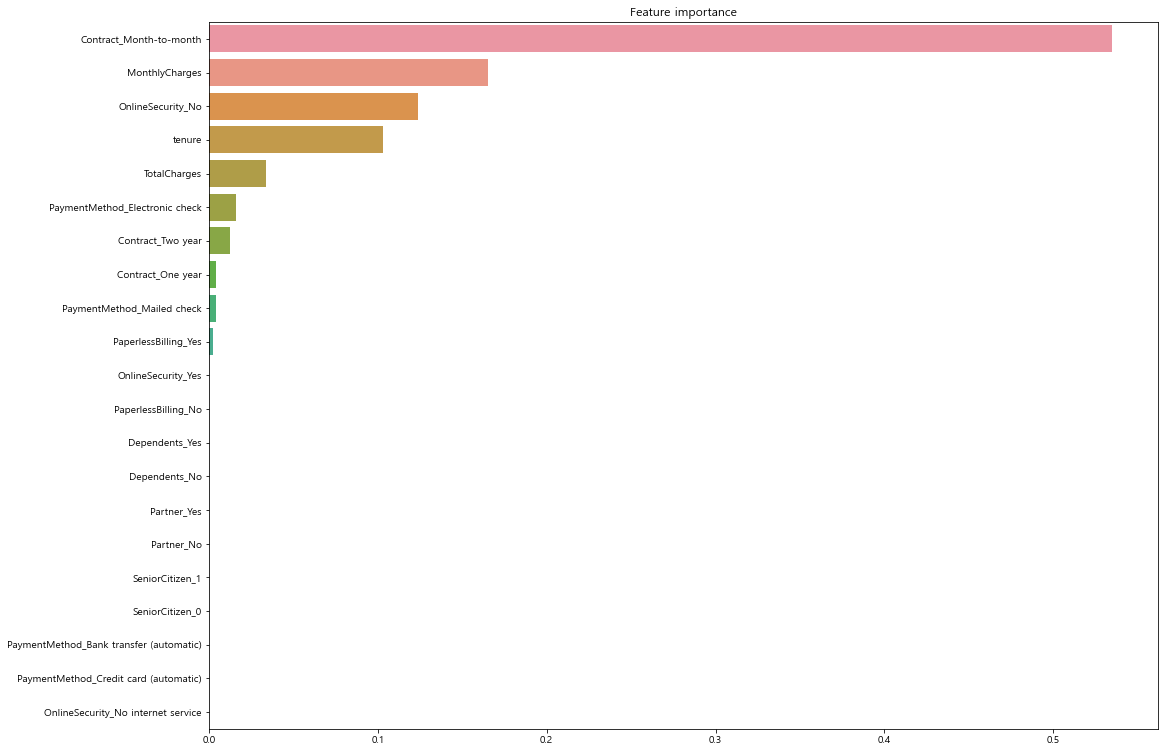

In [44]:
fimp = pd.Series(data=best_dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, orient='h')